# Data Exploration and Preprocessing

In [1]:
import gdown
import zipfile

url = f'https://drive.google.com/uc?id=1aU7Vv7jgodZ0YFOLY7kmSjrPcDDwtRfU'

output = 'imdb_dataset.zip'
gdown.download(url, output)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall()

Downloading...
From (original): https://drive.google.com/uc?id=1aU7Vv7jgodZ0YFOLY7kmSjrPcDDwtRfU
From (redirected): https://drive.google.com/uc?id=1aU7Vv7jgodZ0YFOLY7kmSjrPcDDwtRfU&confirm=t&uuid=a26ad3d9-7310-4f7a-a9c1-37bacdb3d7ef
To: c:\Users\ASUS\Documents\BERT-movie-classifier\imdb_dataset.zip
100%|██████████| 27.0M/27.0M [00:09<00:00, 2.86MB/s]


In [2]:
import pandas as pd

file_path = 'IMDB Dataset.csv'
df = pd.read_csv(file_path)

In [3]:
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
print("Distribution of sentiment labels:")
df['sentiment'].value_counts()

Distribution of sentiment labels:


sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [6]:
import re

def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)
    return text

df['cleaned_review'] = df['review'].apply(preprocess_text)
df['label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
df[['cleaned_review', 'sentiment']].head()

,cleaned_review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


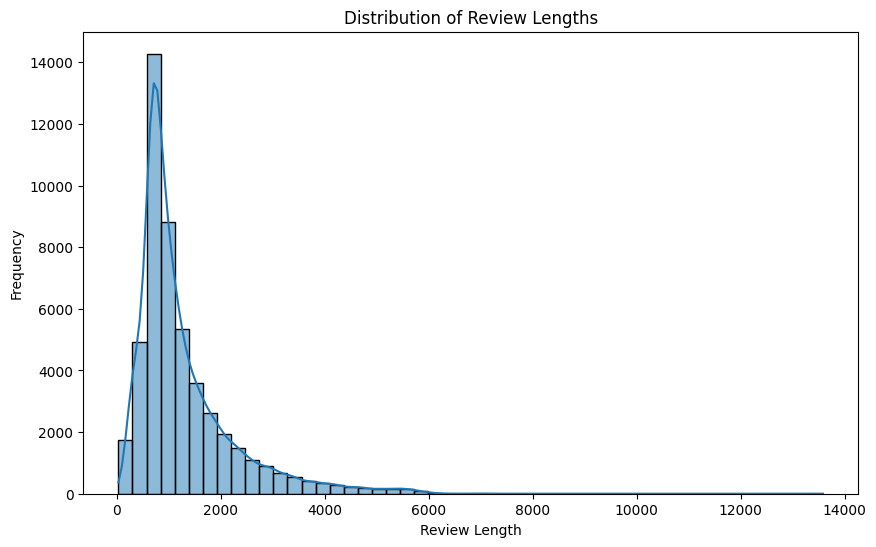

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

df['review_length'] = df['cleaned_review'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

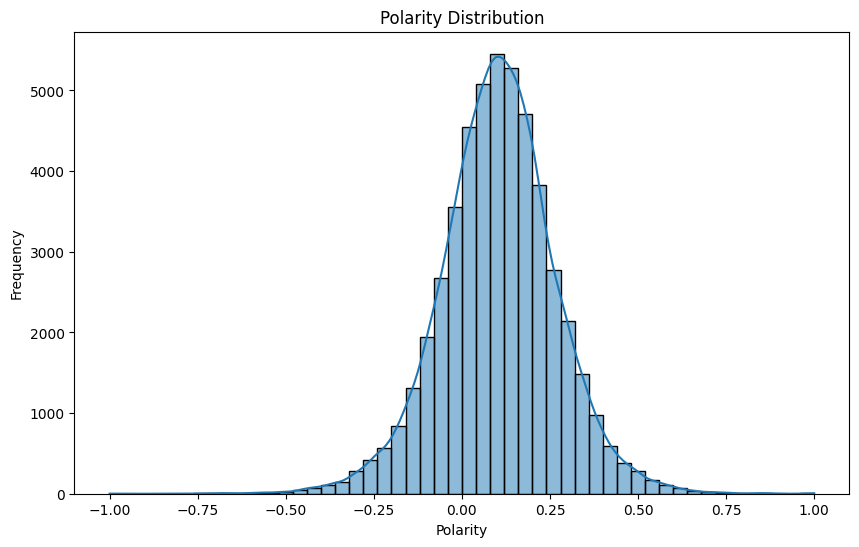

In [8]:
from textblob import TextBlob

df['polarity'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10, 6))
sns.histplot(df['polarity'], bins=50, kde=True)
plt.title('Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.show()

In [9]:
from collections import Counter

class BertTokenizer:
    def __init__(self, max_len):
        self.max_len = max_len
        self.vocab = {"[PAD]": 0, "[UNK]": 1, "[CLS]": 2, "[SEP]": 3}        
        self.vocab_size = len(self.vocab)
        self.inverse_vocab = {v: k for k, v in self.vocab.items()}

    def build_vocab(self, texts, min_freq=2):
        word_counts = Counter()
        for text in texts:
            words = self._tokenize(text)
            word_counts.update(words)

        for word, count in word_counts.items():
            if count >= min_freq and word not in self.vocab:
                self.vocab[word] = self.vocab_size
                self.inverse_vocab[self.vocab_size] = word
                self.vocab_size += 1

    def _tokenize(self, text):
        return text.lower().split()

    def encode(self, text, truncation=False, padding=False):
        tokens = self._tokenize(text)
        if truncation:
            tokens = tokens[:self.max_len - 2]

        tokens = ["[CLS]"] + tokens + ["[SEP]"]
        ids = [self.vocab.get(token, self.vocab["[UNK]"]) for token in tokens]

        attention_mask = [1] * len(ids)

        if padding:
            pad_length = self.max_len - len(ids)
            ids = ids + [self.vocab["[PAD]"]] * pad_length
            attention_mask = attention_mask + [0] * pad_length

        return ids, attention_mask

    def decode(self, ids):
        return " ".join([self.inverse_vocab.get(id, "[UNK]") for id in ids if id != self.vocab["[PAD]"]])

    def __call__(self, texts, truncation=False, padding=False):
        if isinstance(texts, str):
            return self.encode(texts, truncation, padding)
        elif isinstance(texts, list):
            return [self.encode(text, truncation, padding) for text in texts]
        else:
            raise ValueError("Input must be a string or a list of strings")

In [10]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(df['cleaned_review'].to_list(), df['label'].to_list(), test_size=0.2, random_state=42)

tokenizer = BertTokenizer(max_len=512)
tokenizer.build_vocab(train_texts)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

class IMDBDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        input_ids, attention_mask = self.encodings[idx]
        item = {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item
    
train_dataset = IMDBDataset(train_encodings, train_labels)
test_dataset = IMDBDataset(test_encodings, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model Implementation

In [12]:
import torch.nn as nn
import math

class BertEmbeddings(nn.Module):
    def __init__(self, vocab_size, hidden_size, max_position_embeddings, dropout_rate):
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, hidden_size)
        self.position_embeddings = nn.Embedding(max_position_embeddings, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_ids):
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        words_embeddings = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        embeddings = words_embeddings + position_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

class BertSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, dropout_rate):
        super().__init__()
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(hidden_size, self.all_head_size)
        self.key = nn.Linear(hidden_size, self.all_head_size)
        self.value = nn.Linear(hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(dropout_rate)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask=None):
        query_layer = self.transpose_for_scores(self.query(hidden_states))
        key_layer = self.transpose_for_scores(self.key(hidden_states))
        value_layer = self.transpose_for_scores(self.value(hidden_states))

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        return context_layer

class BertLayer(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, intermediate_size, dropout_rate):
        super().__init__()
        self.attention = BertSelfAttention(hidden_size, num_attention_heads, dropout_rate)
        self.intermediate = nn.Linear(hidden_size, intermediate_size)
        self.output = nn.Linear(intermediate_size, hidden_size)
        self.LayerNorm1 = nn.LayerNorm(hidden_size, eps=1e-12)
        self.LayerNorm2 = nn.LayerNorm(hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.GELU()

    def forward(self, hidden_states, attention_mask=None):
        attention_output = self.attention(hidden_states, attention_mask)
        attention_output = self.dropout(attention_output)
        attention_output = self.LayerNorm1(hidden_states + attention_output)

        intermediate_output = self.intermediate(attention_output)
        intermediate_output = self.activation(intermediate_output)
        layer_output = self.output(intermediate_output)
        layer_output = self.dropout(layer_output)
        layer_output = self.LayerNorm2(attention_output + layer_output)

        return layer_output

class BertModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_hidden_layers, num_attention_heads,
                 intermediate_size, max_position_embeddings, dropout_rate):
        super().__init__()
        self.embeddings = BertEmbeddings(vocab_size, hidden_size, max_position_embeddings, dropout_rate)
        self.encoder = nn.ModuleList([BertLayer(hidden_size, num_attention_heads, intermediate_size, dropout_rate)
                                      for _ in range(num_hidden_layers)])
        self.pooler = nn.Linear(hidden_size, hidden_size)
        self.pooler_activation = nn.Tanh()

    def forward(self, input_ids, attention_mask=None):
        embedding_output = self.embeddings(input_ids)

        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)

        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        hidden_states = embedding_output
        for layer in self.encoder:
            hidden_states = layer(hidden_states, extended_attention_mask)

        pooled_output = self.pooler_activation(self.pooler(hidden_states[:, 0]))
        return hidden_states, pooled_output

class BertForSequenceClassification(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_hidden_layers, num_attention_heads,
                 intermediate_size, max_position_embeddings, dropout_rate, num_labels):
        super().__init__()
        self.bert = BertModel(vocab_size, hidden_size, num_hidden_layers, num_attention_heads,
                              intermediate_size, max_position_embeddings, dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None):
        _, pooled_output = self.bert(input_ids, attention_mask)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Training and Evaluation

In [13]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm

model = BertForSequenceClassification(vocab_size=tokenizer.vocab_size,
                                      hidden_size=768,
                                      num_hidden_layers=12,
                                      num_attention_heads=12,
                                      intermediate_size=3072,
                                      max_position_embeddings=tokenizer.max_len,
                                      dropout_rate=0.1,
                                      num_labels=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (AdamW) with weight decay
optimizer = AdamW(
    [
        {"params": [p for n, p in model.bert.embeddings.named_parameters() if p.requires_grad], "lr": 1e-5},
        {"params": [p for n, p in model.bert.encoder.named_parameters() if p.requires_grad], "lr": 2e-5},
        {"params": [p for n, p in model.classifier.named_parameters() if p.requires_grad], "lr": 5e-5}
    ],
    weight_decay=0.01
)

# Scheduler for layer-wise learning rate decay
def lr_lambda(epoch):
    return 1.0 / (1.0 + 0.1 * epoch)

scheduler = LambdaLR(optimizer, lr_lambda)

# Gradient clipping value
max_grad_norm = 1.0

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    train_progress = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")

    for batch in train_progress:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip gradients to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        scheduler.step()

        # Calculate accuracy for this batch
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_progress.set_postfix({"loss": total_loss / (train_progress.n + 1), "accuracy": correct / total})

    model.eval()
    eval_loss = 0
    eval_correct = 0
    eval_total = 0

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            eval_correct += (predicted == labels).sum().item()
            eval_total += labels.size(0)

    eval_accuracy = eval_correct / eval_total
    print(f"Epoch {epoch+1} finished: Training Loss: {total_loss / len(train_dataloader):.4f}, "
          f"Validation Loss: {eval_loss / len(test_dataloader):.4f}, "
          f"Validation Accuracy: {eval_accuracy:.4f}")

Epoch 1/10: 100%|██████████| 2500/2500 [33:03<00:00,  1.26it/s, loss=0.619, accuracy=0.662]


Epoch 1 finished: Training Loss: 0.6193, Validation Loss: 0.5715, Validation Accuracy: 0.7134


Epoch 2/10: 100%|██████████| 2500/2500 [33:04<00:00,  1.26it/s, loss=0.577, accuracy=0.702]


Epoch 2 finished: Training Loss: 0.5769, Validation Loss: 0.5555, Validation Accuracy: 0.7172


Epoch 3/10: 100%|██████████| 2500/2500 [33:06<00:00,  1.26it/s, loss=0.565, accuracy=0.714]


Epoch 3 finished: Training Loss: 0.5645, Validation Loss: 0.5477, Validation Accuracy: 0.7215


Epoch 4/10: 100%|██████████| 2500/2500 [33:07<00:00,  1.26it/s, loss=0.558, accuracy=0.716]


Epoch 4 finished: Training Loss: 0.5581, Validation Loss: 0.5400, Validation Accuracy: 0.7291


Epoch 5/10: 100%|██████████| 2500/2500 [33:05<00:00,  1.26it/s, loss=0.554, accuracy=0.719]


Epoch 5 finished: Training Loss: 0.5540, Validation Loss: 0.5359, Validation Accuracy: 0.7326


Epoch 6/10: 100%|██████████| 2500/2500 [33:04<00:00,  1.26it/s, loss=0.551, accuracy=0.72] 


Epoch 6 finished: Training Loss: 0.5514, Validation Loss: 0.5339, Validation Accuracy: 0.7326


Epoch 7/10: 100%|██████████| 2500/2500 [33:06<00:00,  1.26it/s, loss=0.549, accuracy=0.722]


Epoch 7 finished: Training Loss: 0.5494, Validation Loss: 0.5322, Validation Accuracy: 0.7338


Epoch 8/10: 100%|██████████| 2500/2500 [33:05<00:00,  1.26it/s, loss=0.547, accuracy=0.725]


Epoch 8 finished: Training Loss: 0.5466, Validation Loss: 0.5300, Validation Accuracy: 0.7354


Epoch 9/10: 100%|██████████| 2500/2500 [33:05<00:00,  1.26it/s, loss=0.545, accuracy=0.725]


Epoch 9 finished: Training Loss: 0.5451, Validation Loss: 0.5276, Validation Accuracy: 0.7385


Epoch 10/10: 100%|██████████| 2500/2500 [33:04<00:00,  1.26it/s, loss=0.544, accuracy=0.726]


Epoch 10 finished: Training Loss: 0.5441, Validation Loss: 0.5281, Validation Accuracy: 0.7354


In [14]:
model_save_path = "bert_imdb_model.pth"
torch.save(model.state_dict(), model_save_path)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, test_dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return all_labels, all_preds

def plot_confusion_matrix(all_labels, all_preds):
    conf_matrix = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=0.75, linecolor='black',
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [16]:
all_labels, all_preds = evaluate_model(model, test_dataloader, device)

100%|██████████| 625/625 [06:04<00:00,  1.72it/s]


In [17]:
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive'], digits=4))

              precision    recall  f1-score   support

    Negative     0.6761    0.7208    0.6978      4961
    Positive     0.7060    0.6601    0.6823      5039

    accuracy                         0.6902     10000
   macro avg     0.6911    0.6904    0.6900     10000
weighted avg     0.6912    0.6902    0.6899     10000



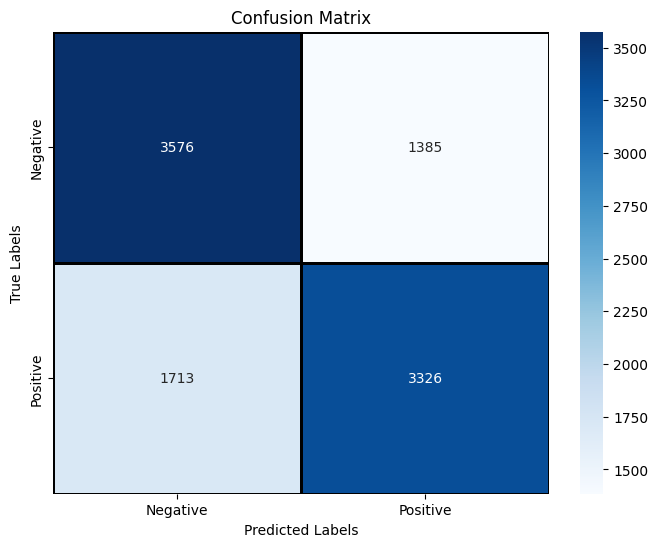

In [18]:
plot_confusion_matrix(all_labels, all_preds)

# Prediction and Inference

In [19]:
def classify_review(review_text):
    encoded_input, attention_mask = tokenizer.encode(review_text, truncation=True, padding=True)
    input_tensor = torch.tensor([encoded_input]).to(device)
    attention_tensor = torch.tensor([attention_mask]).to(device)

    with torch.no_grad():
        logits = model(input_tensor, attention_mask=attention_tensor)
        predicted_class = torch.argmax(logits, dim=1).item()

    return "Positive" if predicted_class == 1 else "Negative"

In [21]:
review_text = "The movie was fantastic with excellent performances!"
result = classify_review(review_text)
print(f"Classification: {result}")

Classification: Positive


In [23]:
review_text = "The plot was boring and the acting was terrible."
result = classify_review(review_text)
print(f"Classification: {result}")

Classification: Negative
